In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pypvcell.spectrum import Spectrum
from pypvcell.illumination import illumination,BpFilter
from pypvcell.photocurrent import calc_jsc,gen_square_qe
from pypvcell.units_system import UnitsSystem
from pypvcell.ivsolver import gen_rec_iv_with_rs_by_newton,gen_rec_iv
from pypvcell.fom import voc,isc,max_power,ff
us=UnitsSystem()

### Show EQE of ST-1 n-type wafer

In [8]:
qe_data=np.loadtxt("st-1-1-1_qe.csv",delimiter='\t')

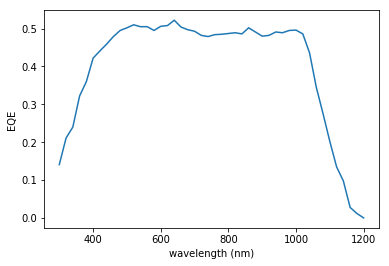

In [9]:
plt.plot(qe_data[:,0],qe_data[:,1])
plt.xlabel("wavelength (nm)")
plt.ylabel("EQE")
plt.savefig("eqe.pdf")

### Calulate photocurrents

In [10]:
eqe=Spectrum(qe_data[:,0],qe_data[:,1],x_unit="nm")
one_sun_ill=illumination()
gaas_filter=BpFilter(1.42,OD=10,f_type='low_pass')

Text(0,0.5,'Irradiance W/nm/m^2')

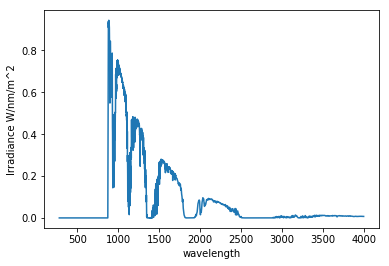

In [11]:
filtered_ill=one_sun_ill*gaas_filter
fi=filtered_ill.get_spectrum(to_x_unit='nm')
plt.plot(fi[0,:],fi[1,:])
plt.xlabel("wavelength")
plt.ylabel("Irradiance W/nm/m^2")

### Calculate Jsc from GaAs-filtered one-sun spectrum

In [12]:
sb_jsc=calc_jsc(filtered_ill,eqe)
print("projected jsc: %s A/m^2"%sb_jsc)

projected jsc: 51.3013945755 A/m^2


In [13]:
full_si_jsc=calc_jsc(one_sun_ill,eqe)
print("projected jsc at full spectrum: %s A/m^2"%full_si_jsc)

projected jsc at full spectrum: 207.890016741 A/m^2


### Caluclate the Jsc limit of GaAs-filtered one-sun spectrum

In [14]:
qe_lim=gen_square_qe(1.1,1)
lim_jsc=calc_jsc(filtered_ill,qe_lim)
print("projected jsc limit:%s"%lim_jsc)

projected jsc limit:119.921228053


### Adding series resistance
Voc of ST1-1-1 is 0.56V

### Compare experiement and simulated I-V (full spectrum)

voc: 0.5677766860165597
voc: 0.5679720402589443
voc: 0.570447084196739
voc: 0.5733271577418948


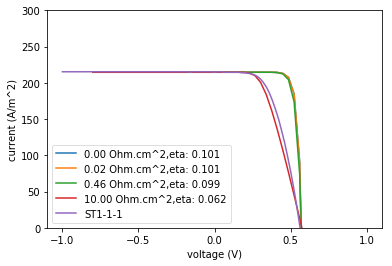

In [15]:
j01 = 5e-8
j02 = 0
n1 = 1
n2 = 2
temperature = 300
rshunt = 1e10

contact_res = np.logspace(-3, 1, num=10)

#Load experiement IV of ST1-1-1
exp_iv=np.loadtxt("ST1-1-1_iv.csv")
cell_isc=isc(exp_iv[:,0],exp_iv[:,1])
cell_area=1.2*1.2
cell_jsc=us.siUnits(cell_isc/cell_area,'mA cm-2')

# rs=1e-10
voltage = np.linspace(-0.8, 1, num=50)
eta_array=np.zeros(contact_res.shape)
for idx,r in enumerate(contact_res):

    rs = us.siUnits(r, 'Ohm cm^2')

    v, i = gen_rec_iv_with_rs_by_newton(j01, j02, n1, n2, temperature, rshunt=rshunt, rseries=rs,
                                        voltage=voltage, jsc=cell_jsc, verbose=False)

    mp = max_power(v, i)
    eta=mp/1000
    #print("voc: %s" % voc(v,i))
    
    eta_array[idx]=eta
    if idx%3==0: 
        plt.plot(v, -i, label="%.2f Ohm.cm^2,eta: %.3f" %(r,eta))
        print("voc: %s" % voc(v,i))



plt.plot(exp_iv[:,0],exp_iv[:,1]/1.44*10,label='ST1-1-1')

plt.legend()
plt.ylim([0, 300])
plt.xlabel("voltage (V)")
plt.ylabel("current (A/m^2)")
plt.savefig("si_I-V.pdf")

### Simulate the I-V at GaAs-filtered spectrum

voc: 0.5308305169228396
voc: 0.5308778934869597
voc: 0.5317531450270555
voc: 0.535748279121854


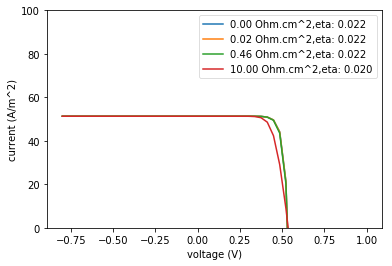

In [16]:
j01 = 5e-8
j02 = 0
n1 = 1
n2 = 2
temperature = 300
rshunt = 1e10

contact_res = np.logspace(-3, 1, num=10)

#Load experiement IV of ST1-1-1
exp_iv=np.loadtxt("ST1-1-1_iv.csv")
cell_isc=isc(exp_iv[:,0],exp_iv[:,1])
cell_area=1.2*1.2
cell_jsc=us.siUnits(cell_isc/cell_area,'mA cm-2')

# rs=1e-10
voltage = np.linspace(-0.8, 1, num=50)
eta_array=np.zeros(contact_res.shape)
for idx,r in enumerate(contact_res):

    rs = us.siUnits(r, 'Ohm cm^2')

    v, i = gen_rec_iv_with_rs_by_newton(j01, j02, n1, n2, temperature, rshunt=rshunt, rseries=rs,
                                        voltage=voltage, jsc=sb_jsc, verbose=False)

    mp = max_power(v, i)
    eta=mp/1000
    #print("voc: %s" % voc(v,i))
    
    eta_array[idx]=eta
    if idx%3==0: 
        plt.plot(v, -i, label="%.2f Ohm.cm^2,eta: %.3f" %(r,eta))
        print("voc: %s" % voc(v,i))


plt.legend()
plt.ylim([0, 100])
plt.xlabel("voltage (V)")
plt.ylabel("current (A/m^2)")
plt.savefig("sb_I-V.pdf")

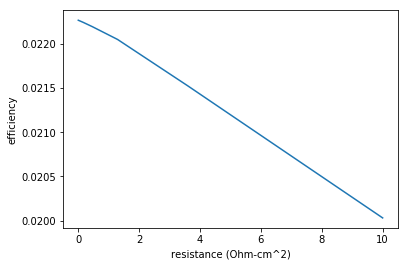

In [17]:
plt.plot(contact_res,eta_array)
plt.xlabel("resistance (Ohm-cm^2)")
plt.ylabel("efficiency")
plt.savefig("eta_rs.pdf")

The infludence of resistance is negligible with given recombination current.

The target efficiency of silicon bottom cell is 5.3%. Wiht this Voc and Jsc, it is difficult to achieve this even with zero series resistance. To achieve more than 30% III-V/Si, I recommmend the target to be at least 6%.

### Investigate the criteria for achieving more than 6%

In [18]:
jsc_range=np.linspace(40,120,num=500)
j01_range=np.logspace(-10,-6,num=500)

eta_array=np.zeros((jsc_range.shape[0],j01_range.shape[0]))
voc_array=np.zeros((j01_range.shape[0],))

for i in range(jsc_range.shape[0]):
    for j in range(j01_range.shape[0]):
        v,current=gen_rec_iv(j01_range[j],0,n1=1,n2=1,temperature=300,
                             voltage=voltage,rshunt=1e10,jsc=jsc_range[i])
        mp = max_power(v, current)
        eta=mp/1000
        eta_array[i,j]=eta
        voc_array[j]=voc(v,current)

Text(0,0.5,'Subcell Jsc (A/m^2)')

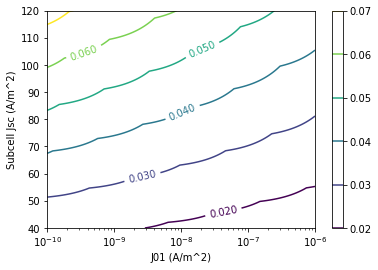

In [19]:
cs=plt.contour(j01_range,jsc_range,eta_array)
plt.xscale("log")
plt.colorbar()
plt.clabel(cs)
plt.xlabel("J01 (A/m^2)")
plt.ylabel("Subcell Jsc (A/m^2)")

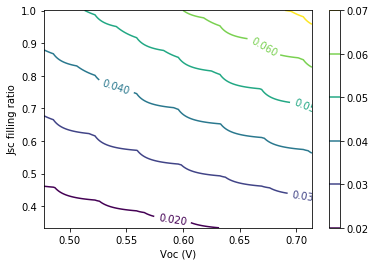

In [20]:
cs=plt.contour(voc_array,jsc_range/lim_jsc,eta_array)
plt.xscale("linear")
plt.colorbar()
plt.clabel(cs)
plt.xlabel("Voc (V)")
plt.ylabel("Jsc filling ratio")
plt.savefig("criteria_contour.pdf")

Note that the above calculation were performed without considering series resistance a shading. 90% EQE and 0.68-V Voc should be the target to achieve.

In [42]:
def lump_r(sw, sl, fw, fh, rho_c, rho_f, rho_sh,rho_cb, N):
    w = sw / N

    pitch = w - fw  # pitch between fingers

    # print("pitch:%s"%pitch)

    Rc = rho_c / (fw * sl)
    
    Rc = np.sqrt(rho_sh*rho_c)/sw/np.tanh(sl*np.sqrt(rho_sh/rho_c))

    Rf = rho_f * (sl / 3) / (fw * fh)

    Rsh = rho_sh * sw
    
    Rb=rho_cb/(w*sl)
    
    R_lump = Rc + Rf + Rsh +Rb
    
    shading=fw/sw

    return R_lump, R_lump * w * sl,shading,{'Rc':Rc,'Rf':Rf,'Rsh':Rsh,'Rb':Rb}

In [49]:
j01 = 5e-8
j02 = 0
n1 = 1
n2 = 2
temperature = 300
rshunt = 1e10

contact_res=np.logspace(0,3,num=5)
fw_arr=us.siUnits(np.linspace(50,200,num=300),'um')


# rs=1e-10
voltage = np.linspace(-0.8, 1, num=300)

eta_array=np.zeros(fw_arr.shape)
rc_ratio=np.zeros(fw_arr.shape)
rsh_ratio=np.zeros(fw_arr.shape)
rf_ratio=np.zeros(fw_arr.shape)
rb_ratio=np.zeros(fw_arr.shape)
total_rc=np.zeros(fw_arr.shape)

for idx,fw in enumerate(fw_arr):

    #rs = us.siUnits(r, 'Ohm cm^2')

    lr, rs, shad,bd = lump_r(us.siUnits(1, "cm"), us.siUnits(1, "cm"),
                   fw, us.siUnits(100, 'nm'),
                   us.siUnits(0.01, "Ohm cm2"), us.siUnits(2.44e-8, "Ohm m"),
                   rho_sh=us.siUnits(26, "Ohm"), 
                             rho_cb=us.siUnits(1.1,"Ohm cm2"),N=7)
    
    
    v, i = gen_rec_iv_with_rs_by_newton(j01, j02, n1, n2, temperature, rshunt=rshunt, rseries=rs,
                                        voltage=voltage, jsc=sb_jsc*(1-shad), verbose=False)

    mp = max_power(v, i)
    eta=mp/1000
    #print("efficiency %s" % eta)
    eta_array[idx]=eta
    rc_ratio[idx]=bd['Rc']/lr
    rsh_ratio[idx]=bd["Rsh"]/lr
    rf_ratio[idx]=bd["Rf"]/lr
    rb_ratio[idx]=bd["Rb"]/lr
    total_rc[idx]=rs

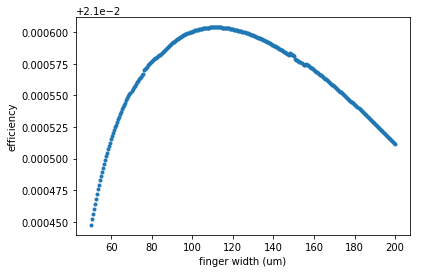

In [50]:
plt.plot(fw_arr*1e6,eta_array,'.')
plt.xlabel("finger width (um)")
plt.ylabel("efficiency")
plt.savefig("eta_finger.pdf")

The above result shows that the optimal finger width is around 150 um, although the influences of finger width is very marginal in this case due to low current density.

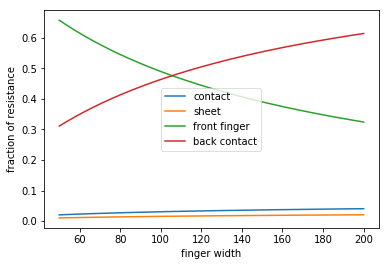

In [51]:
plt.plot(fw_arr*1e6,rc_ratio,label="contact")
plt.plot(fw_arr*1e6,rsh_ratio,label="sheet")
plt.plot(fw_arr*1e6,rf_ratio,label="front finger")
plt.plot(fw_arr*1e6,rb_ratio,label="back contact")
plt.xlabel("finger width")
plt.ylabel("fraction of resistance")
plt.legend()
plt.savefig("res_break_down_100nm.pdf")

Finger resistance is the main source of resistance.

### Assume that we could reduce the recombination current and increase the short-circuit current

Text(0,0.5,'current (A/m^2)')

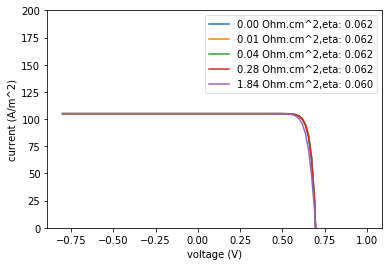

In [46]:
j01 = 2e-10
j02 = 0
n1 = 1
n2 = 2
temperature = 300
rshunt = 1e10

new_jsc=105

contact_res = np.logspace(-3, 1, num=50)

# rs=1e-10
voltage = np.linspace(-0.8, 1, num=100)
eta_array=np.zeros(contact_res.shape)
for idx,r in enumerate(contact_res):

    rs = us.siUnits(r, 'Ohm cm^2')

    v, i = gen_rec_iv_with_rs_by_newton(j01, j02, n1, n2, temperature, rshunt=rshunt, rseries=rs,
                                        voltage=voltage, jsc=new_jsc, verbose=False)

    mp = max_power(v, i)
    eta=mp/1000
    #print("voc: %s" % voc(v,i))
    
    eta_array[idx]=eta
    if idx%10==0: 
        plt.plot(v, -i, label="%.2f Ohm.cm^2,eta: %.3f" %(r,eta))

plt.legend()
plt.ylim([0, 200])
plt.xlabel("voltage (V)")
plt.ylabel("current (A/m^2)")

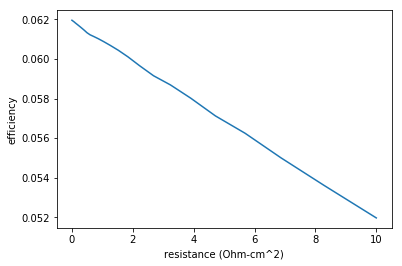

In [47]:
plt.plot(contact_res,eta_array)
plt.xlabel("resistance (Ohm-cm^2)")
plt.ylabel("efficiency")
plt.savefig("ideal_eta_res.pdf")

### Increase the height of the finger

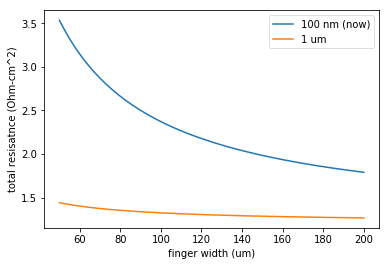

In [48]:
tfw_arr=us.siUnits(np.linspace(50,200,num=300),'um')

rs1_r=[]
rs2_r=[]
for fw in tfw_arr:
    lr, rs1, shad,bd = lump_r(us.siUnits(1, "cm"), us.siUnits(1, "cm"),
                   fw, us.siUnits(100, 'nm'),
                   us.siUnits(0.01, "Ohm cm2"), us.siUnits(2.44e-8, "Ohm m"),
                   rho_sh=us.siUnits(26, "Ohm"), 
                              rho_cb=us.siUnits(1.1,"Ohm cm2"),N=7)

    lr, rs2, shad,bd = lump_r(us.siUnits(1, "cm"), us.siUnits(1, "cm"),
                   fw, us.siUnits(1, 'um'),
                   us.siUnits(0.01, "Ohm cm2"), us.siUnits(2.44e-8, "Ohm m"),
                   rho_sh=us.siUnits(26, "Ohm"), 
                              rho_cb=us.siUnits(1.1,"Ohm cm2"),N=7)
    rs1_r.append(rs1)
    rs2_r.append(rs2)
    
rs1_r=np.array(rs1_r)
rs2_r=np.array(rs2_r)

plt.plot(tfw_arr*1e6,us.convert(rs1_r,'Ohm m^2','Ohm cm^2'),label="100 nm (now)")
plt.plot(tfw_arr*1e6,us.convert(rs2_r,'Ohm m^2','Ohm cm^2'),label="1 um")
plt.ylabel("total resisatnce (Ohm-cm^2)")
plt.xlabel("finger width (um)")
plt.legend()
plt.savefig("tot_res_finger.pdf")

## Observations

1. It is impossilbe to achieve the target simply by optimising the ohmic loss.